# Fabric importance
In this notebook a train test based on weeks 102 and 103 is created,
then a test set on week 104 is also created, and used here and in other experiments

### Import of libraries and datasets

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
articles = pd.read_parquet("../generated_data/articles_with_fabric_namenum.parquet")
articles

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,fabric_num,fabric_name
0,108775015,108775,12855,253,9,0,1010016,0,9,0,...,0,1,0,16,30,1002,2,8834,[0],[jersey]
1,108775044,108775,12855,253,9,0,1010016,0,10,2,...,0,1,0,16,30,1002,2,8834,[0],[jersey]
2,108775051,108775,44846,253,9,0,1010017,3,11,11,...,0,1,0,16,30,1002,2,8834,[0],[jersey]
3,110065001,110065,8159,306,13,4,1010016,0,9,0,...,7,1,0,61,5,1017,4,8243,[1],[microfibre]
4,110065002,110065,8159,306,13,4,1010016,0,10,2,...,7,1,0,61,5,1017,4,8243,[1],[microfibre]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105537,953450001,953450,24043,302,14,7,1010014,6,9,0,...,2,3,3,26,16,1021,13,28026,"[4, 13, 3]","[cotton, knit, elastic]"
105538,953763001,953763,24027,253,9,0,1010016,0,9,0,...,0,1,0,2,15,1005,0,28025,[8],[polyester]
105539,956217002,956217,24040,265,1,2,1010016,0,9,0,...,0,1,0,18,12,1005,0,28024,[0],[jersey]
105540,957375001,957375,24041,72,48,3,1010016,0,9,0,...,1,2,2,52,25,1019,1,28023,"[5, 6]","[plastic, hair]"


In [8]:
a2 = pd.read_csv("../data/articles.csv")

In [9]:
style_cols = ["graphical_appearance_name", "perceived_colour_master_name", "section_name", "index_group_name"]
for col in style_cols:
    print(col)
    print(a2[col].unique())
    print()

graphical_appearance_name
['Solid' 'Stripe' 'All over pattern' 'Melange' 'Transparent' 'Metallic'
 'Application/3D' 'Denim' 'Colour blocking' 'Dot' 'Other structure'
 'Contrast' 'Treatment' 'Check' 'Chambray' 'Front print'
 'Glittering/Metallic' 'Mixed solid/pattern' 'Placement print'
 'Other pattern' 'Neps' 'Embroidery' 'Lace' 'Jacquard' 'Unknown' 'Argyle'
 'Slub' 'Mesh' 'Sequin' 'Hologram']

perceived_colour_master_name
['Black' 'White' 'Beige' 'Grey' 'Blue' 'Pink' 'Lilac Purple' 'Red' 'Mole'
 'Orange' 'Metal' 'Brown' 'Turquoise' 'Yellow' 'Khaki green' 'Green'
 'undefined' 'Unknown' 'Yellowish Green' 'Bluish Green']

section_name
['Womens Everyday Basics' 'Womens Lingerie'
 'Womens Nightwear, Socks & Tigh' 'Baby Essentials & Complements'
 'Men Underwear' 'Mama' 'Womens Small accessories' 'Men H&M Sport'
 'Kids Boy' 'Divided Basics' 'Girls Underwear & Basics' 'Mens Outerwear'
 'Womens Big accessories' 'Divided Accessories'
 'Womens Swimwear, beachwear' 'Divided Selected' 'Boys Underwe

In [10]:
customers = pd.read_parquet("../data/customers.parquet")
customers

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,6883939031699146327,-1,-1,0,0,49,6305
1,11246327431398957306,-1,-1,0,0,25,33726
2,18439897732908966680,-1,-1,0,0,24,3247
3,18352672461570950206,-1,-1,0,0,54,168643
4,18162778555210377306,1,1,0,1,52,168645
...,...,...,...,...,...,...,...
1371975,7551062398649767985,-1,-1,0,0,24,50351
1371976,9305341941720086711,-1,-1,0,0,21,80169
1371977,10160427316885688932,1,1,0,1,21,106737
1371978,2551401172826382186,1,1,0,1,18,111894


In [11]:
#Limit transactions to THIS FALL:
#TRAIN = WEEK 102-103 
#TEST = WEEK 104
tr = pd.read_parquet("../generated_data/trans_art_102_to_104.parquet")
tr.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,product_code,prod_name,product_type_no,product_type_name,...,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,fabric_num,fabric_name
252,2020-09-03,5316172648860712200,578472001,0.076254,2,102,578472,37340,263,38,...,0,1,0,19,40,1007,9,26053,[-1],None
253,2020-09-16,6474552940938576885,578472001,0.091508,2,104,578472,37340,263,38,...,0,1,0,19,40,1007,9,26053,[-1],None
6203,2020-09-10,5701871825794564345,613246004,0.021169,1,103,613246,5006,272,0,...,0,1,0,15,0,1009,5,3016,"[11, 12]","[denim, jeans]"
10396,2020-09-21,6949189610971841595,688873001,0.003373,1,104,688873,131,258,5,...,0,1,0,11,7,1010,6,22,[-1],None
10704,2020-09-11,2430626937109945466,673911002,0.013542,1,103,673911,11338,94,16,...,6,1,0,64,20,1020,7,7204,"[3, 16]","[elastic, suede]"


In [12]:
tr_this_fall = tr[(tr.week > 101) & (tr.week < 104)]
print(tr_this_fall.shape)

tr_this_fall_test = tr[(tr.week == 104)]
print(tr_this_fall_test.shape)

(519898, 32)
(240311, 32)


In [13]:
cus_this_fall = tr_this_fall["customer_id"].unique().tolist()
len(cus_this_fall)

133883

In [14]:
cus_this_fall_test = tr_this_fall_test["customer_id"].unique().tolist()
len(cus_this_fall_test)

68984

In [15]:
art_this_fall = tr_this_fall["article_id"].unique().tolist()
len(art_this_fall)

23518

In [16]:
art_this_fall_test = tr_this_fall_test["article_id"].unique().tolist()
len(art_this_fall_test)

17986

### Articles Matrix

In [17]:
#create the correspondence between article id and index
index_to_art_id = pd.DataFrame({'article_id': art_this_fall})
index_to_art_id_test = pd.DataFrame({'article_id': art_this_fall_test})

In [18]:
index_to_art_id.sort_values(by='article_id')
index_to_art_id['original_index'] = index_to_art_id.index
index_to_art_id.head()

,article_id,original_index
0,578472001,0
1,613246004,1
2,673911002,2
3,568601006,3
4,621381011,4


In [19]:
index_to_art_id_test.sort_values(by='article_id')
index_to_art_id_test['original_index'] = index_to_art_id_test.index
index_to_art_id_test.head()

,article_id,original_index
0,578472001,0
1,688873001,1
2,568601006,2
3,573937001,3
4,480093001,4


In [20]:
#considering just the articles in the weeks we're interested in
articles_this_fall = articles[articles['article_id'].isin(art_this_fall)]
articles_this_fall_test = articles[articles['article_id'].isin(art_this_fall_test)]

In [21]:
#creating reduced datasets for the style characteristics
articles_this_fall_fabric = articles_this_fall[['article_id', 'fabric_num']]
articles_this_fall_style = articles_this_fall[["article_id", "graphical_appearance_name", "perceived_colour_master_name", "section_name", "index_group_name"]]
articles_this_fall_fabric_test = articles_this_fall_test[['article_id', 'fabric_num']]
articles_this_fall_style_test = articles_this_fall_test[["article_id", "graphical_appearance_name", "perceived_colour_master_name", "section_name", "index_group_name"]]

print("training")
print(articles_this_fall_fabric.shape)
print(articles_this_fall_style.shape)
print("test")
print(articles_this_fall_fabric_test.shape)
print(articles_this_fall_style_test.shape)

training
(23518, 2)
(23518, 5)
test
(17986, 2)
(17986, 5)


In [22]:
#creating matrix for fabric

from sklearn.preprocessing import MultiLabelBinarizer

#I make sure that every value inside fabric num lists is counted as a possible value
mlb = MultiLabelBinarizer(sparse_output=True)

articles_this_fall_fabric = articles_this_fall_fabric.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(articles_this_fall_fabric.pop('fabric_num')),
                index=articles_this_fall_fabric.index,
                columns=mlb.classes_))

articles_this_fall_fabric.head()

,article_id,-1,0,1,2,3,4,5,6,7,...,90,91,92,94,95,97,99,100,103,104
1,108775044,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,111565001,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,111586001,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,111593001,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,111609001,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
#I make sure that every value inside fabric num lists is counted as a possible value
mlb = MultiLabelBinarizer(sparse_output=True)

articles_this_fall_fabric_test = articles_this_fall_fabric_test.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(articles_this_fall_fabric_test.pop('fabric_num')),
                index=articles_this_fall_fabric_test.index,
                columns=mlb.classes_))

articles_this_fall_fabric_test.head()

,article_id,-1,0,1,2,3,4,5,6,7,...,82,83,84,90,91,92,94,97,101,103
1,108775044,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,111565001,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,111586001,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,111593001,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,111609001,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
#remove article id
articles_this_fall_fabric = articles_this_fall_fabric.drop(['article_id'], axis=1)
#remove article id
articles_this_fall_fabric_test = articles_this_fall_fabric_test.drop(['article_id'], axis=1)

In [25]:
#creating matrix for other features
one_hot_encoded = pd.get_dummies(articles_this_fall[['graphical_appearance_name', 'perceived_colour_master_name', 'section_name', 'index_group_name']], columns=['graphical_appearance_name', 'perceived_colour_master_name', 'section_name', 'index_group_name'])
one_hot_encoded = one_hot_encoded.astype(int)
one_hot_encoded

,graphical_appearance_name_0,graphical_appearance_name_1,graphical_appearance_name_2,graphical_appearance_name_3,graphical_appearance_name_4,graphical_appearance_name_5,graphical_appearance_name_6,graphical_appearance_name_7,graphical_appearance_name_8,graphical_appearance_name_9,...,section_name_49,section_name_50,section_name_52,section_name_54,section_name_55,index_group_name_0,index_group_name_1,index_group_name_2,index_group_name_3,index_group_name_4
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
105536,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
105537,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
105538,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [26]:
one_hot_encoded_test = pd.get_dummies(articles_this_fall_test[['graphical_appearance_name', 'perceived_colour_master_name', 'section_name', 'index_group_name']], columns=['graphical_appearance_name', 'perceived_colour_master_name', 'section_name', 'index_group_name'])
one_hot_encoded_test = one_hot_encoded_test.astype(int)
one_hot_encoded_test

,graphical_appearance_name_0,graphical_appearance_name_1,graphical_appearance_name_2,graphical_appearance_name_3,graphical_appearance_name_4,graphical_appearance_name_5,graphical_appearance_name_6,graphical_appearance_name_7,graphical_appearance_name_8,graphical_appearance_name_9,...,section_name_48,section_name_49,section_name_52,section_name_54,section_name_55,index_group_name_0,index_group_name_1,index_group_name_2,index_group_name_3,index_group_name_4
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
105536,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
105537,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
105538,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [27]:
#merge the two matrices
merged_matrix_art = one_hot_encoded.join(articles_this_fall_fabric)
merged_matrix_art_test = one_hot_encoded_test.join(articles_this_fall_fabric_test)

In [28]:
merged_matrix_art = csr_matrix(merged_matrix_art.values)
print(merged_matrix_art)

  (0, 0)	1
  (0, 31)	1
  (0, 79)	1
  (0, 102)	1
  (0, 108)	1
  (1, 0)	1
  (1, 29)	1
  (1, 80)	1
  (1, 102)	1
  (1, 110)	1
  (2, 0)	1
  (2, 29)	1
  (2, 80)	1
  (2, 102)	1
  (2, 107)	1
  (3, 0)	1
  (3, 29)	1
  (3, 80)	1
  (3, 102)	1
  (3, 111)	1
  (4, 0)	1
  (4, 29)	1
  (4, 80)	1
  (4, 102)	1
  (4, 107)	1
  :	:
  (23513, 102)	1
  (23513, 111)	1
  (23513, 121)	1
  (23514, 1)	1
  (23514, 43)	1
  (23514, 61)	1
  (23514, 102)	1
  (23514, 108)	1
  (23515, 6)	1
  (23515, 29)	1
  (23515, 65)	1
  (23515, 105)	1
  (23515, 111)	1
  (23515, 112)	1
  (23515, 121)	1
  (23516, 0)	1
  (23516, 29)	1
  (23516, 64)	1
  (23516, 102)	1
  (23516, 116)	1
  (23517, 0)	1
  (23517, 29)	1
  (23517, 61)	1
  (23517, 102)	1
  (23517, 108)	1


In [29]:
merged_matrix_art_test = csr_matrix(merged_matrix_art_test.values)
print(merged_matrix_art_test)

  (0, 0)	1
  (0, 31)	1
  (0, 78)	1
  (0, 101)	1
  (0, 107)	1
  (1, 0)	1
  (1, 29)	1
  (1, 79)	1
  (1, 101)	1
  (1, 109)	1
  (2, 0)	1
  (2, 29)	1
  (2, 79)	1
  (2, 101)	1
  (2, 106)	1
  (3, 0)	1
  (3, 29)	1
  (3, 79)	1
  (3, 101)	1
  (3, 110)	1
  (4, 0)	1
  (4, 29)	1
  (4, 79)	1
  (4, 101)	1
  (4, 106)	1
  :	:
  (17981, 101)	1
  (17981, 110)	1
  (17981, 120)	1
  (17982, 1)	1
  (17982, 43)	1
  (17982, 60)	1
  (17982, 101)	1
  (17982, 107)	1
  (17983, 6)	1
  (17983, 29)	1
  (17983, 64)	1
  (17983, 104)	1
  (17983, 110)	1
  (17983, 111)	1
  (17983, 120)	1
  (17984, 0)	1
  (17984, 29)	1
  (17984, 63)	1
  (17984, 101)	1
  (17984, 115)	1
  (17985, 0)	1
  (17985, 29)	1
  (17985, 60)	1
  (17985, 101)	1
  (17985, 107)	1


In [30]:
print(merged_matrix_art.shape)
print(merged_matrix_art_test.shape)

(23518, 196)
(17986, 186)


### Customer Style Matrix

In [31]:
#saving the correspondence between customer id and index
index_to_cus_id = pd.DataFrame({'customer_id': cus_this_fall})
index_to_cus_id_test = pd.DataFrame({'customer_id': cus_this_fall_test})

In [32]:
index_to_cus_id.sort_values(by='customer_id')
index_to_cus_id['original_index'] = index_to_cus_id.index
index_to_cus_id.head()

,customer_id,original_index
0,5316172648860712200,0
1,5701871825794564345,1
2,2430626937109945466,2
3,1554451040316070853,3
4,1894787043365243217,4


In [33]:
index_to_cus_id_test.sort_values(by='customer_id')
index_to_cus_id_test['original_index'] = index_to_cus_id_test.index
index_to_cus_id_test.head()

,customer_id,original_index
0,6474552940938576885,0
1,6949189610971841595,1
2,243360189732505689,2
3,755293567580339219,3
4,2805267957821275519,4


In [34]:
#creating reduced datasets for style characteristics
customers_this_fall_fabric = tr_this_fall[['customer_id', 'fabric_num']]
customers_this_fall_style = tr_this_fall[["customer_id", "graphical_appearance_name", "perceived_colour_master_name", "section_name", "index_group_name"]]
customers_this_fall_fabric_test = tr_this_fall_test[['customer_id', 'fabric_num']]
customers_this_fall_style_test = tr_this_fall_test[["customer_id", "graphical_appearance_name", "perceived_colour_master_name", "section_name", "index_group_name"]]

print("training")
print(customers_this_fall_fabric.shape)
print(customers_this_fall_style.shape)
print("test")
print(customers_this_fall_fabric_test.shape)
print(customers_this_fall_style_test.shape)

training
(519898, 2)
(519898, 5)
test
(240311, 2)
(240311, 5)


In [35]:
print(index_to_cus_id.shape)
print(index_to_cus_id_test.shape)

(133883, 2)
(68984, 2)


In [36]:
#creating matrix for fabric

from sklearn.preprocessing import MultiLabelBinarizer

#I make sure that every value inside fabric num lists is counted as a possible value
mlb = MultiLabelBinarizer(sparse_output=True)

customers_this_fall_fabric = customers_this_fall_fabric.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(customers_this_fall_fabric.pop('fabric_num')),
                index=customers_this_fall_fabric.index,
                columns=mlb.classes_))

customers_this_fall_fabric.head()

,customer_id,-1,0,1,2,3,4,5,6,7,...,90,91,92,94,95,97,99,100,103,104
252,5316172648860712200,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6203,5701871825794564345,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10704,2430626937109945466,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35249,1554451040316070853,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35250,1894787043365243217,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
#I make sure that every value inside fabric num lists is counted as a possible value
mlb = MultiLabelBinarizer(sparse_output=True)

customers_this_fall_fabric_test = customers_this_fall_fabric_test.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(customers_this_fall_fabric_test.pop('fabric_num')),
                index=customers_this_fall_fabric_test.index,
                columns=mlb.classes_))

customers_this_fall_fabric_test.head()

,customer_id,-1,0,1,2,3,4,5,6,7,...,82,83,84,90,91,92,94,97,101,103
253,6474552940938576885,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10396,6949189610971841595,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35695,243360189732505689,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35696,755293567580339219,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35697,2805267957821275519,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
customers_this_fall_fabric = customers_this_fall_fabric.groupby('customer_id').sum()
customers_this_fall_fabric_test = customers_this_fall_fabric_test.groupby('customer_id').sum()
customers_this_fall_fabric_test.head()

,-1,0,1,2,3,4,5,6,7,8,...,82,83,84,90,91,92,94,97,101,103
customer_id,,,,,,,,,,,,,,,,,,,,,
1402273113592184,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1827730561464445,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1951136007097426,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2639747769247776,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3177658828628418,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
customers_this_fall_fabric.sort_values(by='customer_id')
customers_this_fall_fabric_test.sort_values(by='customer_id')

,-1,0,1,2,3,4,5,6,7,8,...,82,83,84,90,91,92,94,97,101,103
customer_id,,,,,,,,,,,,,,,,,,,,,
1402273113592184,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1827730561464445,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1951136007097426,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2639747769247776,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3177658828628418,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18444954504588539615,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18445164350380731040,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18445340048433064259,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
sparse_cus_fabric = csr_matrix(customers_this_fall_fabric.values)
sparse_cus_fabric_test = csr_matrix(customers_this_fall_fabric_test.values)
sparse_cus_fabric_test

<68984x80 sparse matrix of type '<class 'numpy.intc'>'
	with 244449 stored elements in Compressed Sparse Row format>

In [41]:
#creating matrix for other stye characteristics

one_hot_encoded = pd.get_dummies(tr_this_fall[['graphical_appearance_name', 'perceived_colour_master_name', 'section_name', 'index_group_name']], columns=['graphical_appearance_name', 'perceived_colour_master_name', 'section_name', 'index_group_name'])
one_hot_encoded = one_hot_encoded.astype(int)

one_hot_encoded_test = pd.get_dummies(tr_this_fall_test[['graphical_appearance_name', 'perceived_colour_master_name', 'section_name', 'index_group_name']], columns=['graphical_appearance_name', 'perceived_colour_master_name', 'section_name', 'index_group_name'])
one_hot_encoded_test = one_hot_encoded_test.astype(int)
one_hot_encoded_test

,graphical_appearance_name_0,graphical_appearance_name_1,graphical_appearance_name_2,graphical_appearance_name_3,graphical_appearance_name_4,graphical_appearance_name_5,graphical_appearance_name_6,graphical_appearance_name_7,graphical_appearance_name_8,graphical_appearance_name_9,...,section_name_48,section_name_49,section_name_52,section_name_54,section_name_55,index_group_name_0,index_group_name_1,index_group_name_2,index_group_name_3,index_group_name_4
253,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10396,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
35695,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
35696,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
35697,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31788319,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
31788320,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
31788321,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
31788322,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [42]:
one_hot_encoded['customer_id'] = tr_this_fall['customer_id']
one_hot_encoded_test['customer_id'] = tr_this_fall_test['customer_id']
one_hot_encoded_test.head()

,graphical_appearance_name_0,graphical_appearance_name_1,graphical_appearance_name_2,graphical_appearance_name_3,graphical_appearance_name_4,graphical_appearance_name_5,graphical_appearance_name_6,graphical_appearance_name_7,graphical_appearance_name_8,graphical_appearance_name_9,...,section_name_49,section_name_52,section_name_54,section_name_55,index_group_name_0,index_group_name_1,index_group_name_2,index_group_name_3,index_group_name_4,customer_id
253,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,6474552940938576885
10396,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,6949189610971841595
35695,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,243360189732505689
35696,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,755293567580339219
35697,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2805267957821275519


In [43]:
one_hot_encoded = one_hot_encoded.groupby('customer_id').sum()
one_hot_encoded_test = one_hot_encoded_test.groupby('customer_id').sum()
one_hot_encoded_test.head()

,graphical_appearance_name_0,graphical_appearance_name_1,graphical_appearance_name_2,graphical_appearance_name_3,graphical_appearance_name_4,graphical_appearance_name_5,graphical_appearance_name_6,graphical_appearance_name_7,graphical_appearance_name_8,graphical_appearance_name_9,...,section_name_48,section_name_49,section_name_52,section_name_54,section_name_55,index_group_name_0,index_group_name_1,index_group_name_2,index_group_name_3,index_group_name_4
customer_id,,,,,,,,,,,,,,,,,,,,,
1402273113592184,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
1827730561464445,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
1951136007097426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2639747769247776,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3177658828628418,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [44]:
one_hot_encoded_test.shape

(68984, 106)

In [45]:
#merge the two matrices
merged_cus = pd.merge(customers_this_fall_fabric, one_hot_encoded, on="customer_id", how="inner")
merged_cus.sort_values(by='customer_id')

merged_cus_test = pd.merge(customers_this_fall_fabric_test, one_hot_encoded_test, on="customer_id", how="inner")
merged_cus_test.sort_values(by='customer_id')

merged_cus_test


,-1,0,1,2,3,4,5,6,7,8,...,section_name_48,section_name_49,section_name_52,section_name_54,section_name_55,index_group_name_0,index_group_name_1,index_group_name_2,index_group_name_3,index_group_name_4
customer_id,,,,,,,,,,,,,,,,,,,,,
1402273113592184,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
1827730561464445,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,2,0,0,0,0
1951136007097426,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2639747769247776,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3177658828628418,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18444954504588539615,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
18445164350380731040,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18445340048433064259,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [46]:
merged_cus = merged_cus.reset_index()
merged_cus_test = merged_cus_test.reset_index()
merged_cus_test

,customer_id,-1,0,1,2,3,4,5,6,7,...,section_name_48,section_name_49,section_name_52,section_name_54,section_name_55,index_group_name_0,index_group_name_1,index_group_name_2,index_group_name_3,index_group_name_4
0,1402273113592184,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
1,1827730561464445,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,2,0,0,0,0
2,1951136007097426,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,2639747769247776,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,3177658828628418,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68979,18444954504588539615,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
68980,18445164350380731040,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
68981,18445340048433064259,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
68982,18445641720816255142,2,1,0,0,0,3,0,0,0,...,0,0,0,0,0,5,0,2,0,0


In [47]:
merged_cus = merged_cus.drop("customer_id", axis=1)
merged_cus_test = merged_cus_test.drop("customer_id", axis=1)

In [48]:
merged_cus_test.shape

(68984, 186)

In [49]:
merged_cus_test.head()

,-1,0,1,2,3,4,5,6,7,8,...,section_name_48,section_name_49,section_name_52,section_name_54,section_name_55,index_group_name_0,index_group_name_1,index_group_name_2,index_group_name_3,index_group_name_4
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
1,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,2,0,0,0,0
2,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [50]:
merged_cus.columns = merged_cus.columns.astype(str)
merged_cus_test.columns = merged_cus_test.columns.astype(str)

In [51]:
#scale the values between 0 and 1

from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
merged_cus = scaler.fit_transform(merged_cus)
merged_cus_test = scaler.fit_transform(merged_cus_test)

C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [52]:
matrice_sparsa_2 = csr_matrix(merged_cus)
matrice_sparsa_2_test = csr_matrix(merged_cus_test)
print(matrice_sparsa_2_test)

  (0, 11)	0.07142857142857142
  (0, 27)	0.07692307692307693
  (0, 80)	0.0273972602739726
  (0, 109)	0.05263157894736842
  (0, 133)	0.07142857142857142
  (0, 181)	0.025974025974025976
  (1, 5)	0.027777777777777776
  (1, 9)	0.05555555555555555
  (1, 12)	0.020833333333333332
  (1, 14)	0.027777777777777776
  (1, 25)	0.058823529411764705
  (1, 28)	0.07692307692307693
  (1, 80)	0.0136986301369863
  (1, 84)	0.027777777777777776
  (1, 110)	0.03571428571428571
  (1, 123)	0.045454545454545456
  (1, 128)	0.047619047619047616
  (1, 181)	0.025974025974025976
  (2, 4)	0.024390243902439025
  (2, 5)	0.027777777777777776
  (2, 97)	0.2
  (2, 123)	0.045454545454545456
  (2, 159)	0.05555555555555555
  (2, 181)	0.012987012987012988
  (3, 9)	0.05555555555555555
  :	:
  (68982, 82)	0.05263157894736842
  (68982, 84)	0.05555555555555555
  (68982, 87)	0.047619047619047616
  (68982, 109)	0.10526315789473684
  (68982, 110)	0.03571428571428571
  (68982, 116)	0.1
  (68982, 120)	0.14285714285714285
  (68982, 128)	0.

### Compute similarity between articles and customer style

In [53]:
similarity_matrix_sparse = cosine_similarity(matrice_sparsa_2,merged_matrix_art, dense_output=False)
similarity_matrix_sparse_test = cosine_similarity(matrice_sparsa_2_test, merged_matrix_art_test, dense_output=False)

In [54]:
import util
%run util.py

In [ ]:
topk = get_top_K_values(similarity_matrix_sparse, 2)
print(topk)

In [ ]:
topk_test = get_top_K_values(similarity_matrix_sparse_test, 2)
print(topk_test)

In [55]:
toprank = get_top_K_ranks(similarity_matrix_sparse, 3)
print(toprank)

  (0, 12850)	3
  (0, 14189)	1
  (0, 15651)	2
  (1, 13639)	3
  (1, 14294)	1
  (1, 14356)	2
  (2, 2865)	1
  (2, 16632)	3
  (2, 16634)	2
  (3, 12447)	2
  (3, 12519)	1
  (3, 14897)	3
  (4, 440)	1
  (4, 5350)	3
  (4, 6708)	2
  (5, 13639)	1
  (5, 14294)	2
  (5, 14356)	3
  (6, 10149)	2
  (6, 10235)	3
  (6, 21153)	1
  (7, 1899)	3
  (7, 4500)	1
  (7, 4978)	2
  (8, 2237)	1
  :	:
  (133874, 13110)	1
  (133875, 12700)	3
  (133875, 18469)	2
  (133875, 21150)	1
  (133876, 4298)	1
  (133876, 10419)	3
  (133876, 10800)	2
  (133877, 2865)	3
  (133877, 16643)	1
  (133877, 23324)	2
  (133878, 2363)	1
  (133878, 14813)	3
  (133878, 14814)	2
  (133879, 9534)	1
  (133879, 22176)	3
  (133879, 22177)	2
  (133880, 393)	3
  (133880, 398)	2
  (133880, 1357)	1
  (133881, 893)	3
  (133881, 7724)	1
  (133881, 7725)	2
  (133882, 496)	3
  (133882, 1050)	2
  (133882, 12256)	1


In [56]:
toprank_test = get_top_K_ranks(similarity_matrix_sparse_test, 3)
print(toprank_test)

  (0, 5450)	3
  (0, 6756)	2
  (0, 6757)	1
  (1, 3235)	1
  (1, 10885)	3
  (1, 14250)	2
  (2, 2294)	2
  (2, 10895)	1
  (2, 15274)	3
  (3, 1641)	1
  (3, 2855)	3
  (3, 3034)	2
  (4, 4700)	1
  (4, 5511)	3
  (4, 7432)	2
  (5, 3305)	2
  (5, 3308)	3
  (5, 7742)	1
  (6, 207)	2
  (6, 287)	3
  (6, 14275)	1
  (7, 5085)	1
  (7, 9624)	2
  (7, 17042)	3
  (8, 10491)	2
  :	:
  (68975, 8968)	2
  (68976, 6696)	1
  (68976, 7899)	2
  (68976, 14944)	3
  (68977, 2523)	1
  (68977, 6593)	2
  (68977, 6594)	3
  (68978, 6867)	3
  (68978, 13878)	1
  (68978, 16262)	2
  (68979, 6574)	3
  (68979, 6577)	2
  (68979, 11014)	1
  (68980, 1516)	1
  (68980, 10546)	3
  (68980, 13297)	2
  (68981, 7432)	2
  (68981, 16918)	1
  (68981, 17041)	3
  (68982, 5980)	2
  (68982, 5981)	1
  (68982, 17085)	3
  (68983, 2300)	2
  (68983, 2312)	1
  (68983, 5751)	3


In [57]:
V = toprank.data 
U = toprank.indices  # rows indexes
I = toprank.indptr  # cols indexes

print("Values (V):", V[:3])
print("Rows (U):", U[:3])
print("Columns (I):", I[:3])

Values (V): [3 1 2]
Rows (U): [12850 14189 15651]
Columns (I): [0 3 6]


In [58]:
## TRAIN

num_elements = len(V)

neg_train = pd.DataFrame(columns=['id', 'index_1', 'index_2', 'index_3'])

# Per ogni primo elemento, estrai gli indici corrispondenti
for i in range(len(I) - 1):
    start_idx = I[i]
    end_idx = I[i + 1]
    
    # Gli indici corrispondenti al primo elemento
    first_element_indices = U[start_idx:end_idx]
    
    df_to_append = pd.DataFrame({'id': [i], 'index_1': [first_element_indices[0]],
                                 'index_2': [first_element_indices[1]],
                                 'index_3': [first_element_indices[2]]})
    neg_train = pd.concat([neg_train, df_to_append], ignore_index=True)

In [59]:
Vt = toprank_test.data 
Ut = toprank_test.indices  
It = toprank_test.indptr   

print("Values (V):", Vt[:3])
print("Rows (U):", Ut[:3])
print("Columns (I):", It[:3])

Values (V): [3 2 1]
Rows (U): [5450 6756 6757]
Columns (I): [0 3 6]


In [60]:
# TEST

num_elements = len(Vt)

neg_train_test = pd.DataFrame(columns=['id', 'index_1', 'index_2', 'index_3'])

# Per ogni primo elemento, estrai gli indici corrispondenti
for i in range(len(It) - 1):
    start_idx = It[i]
    end_idx = It[i + 1]
    
    # Gli indici corrispondenti al primo elemento
    first_element_indices = Ut[start_idx:end_idx]
    
    df_to_append_test = pd.DataFrame({'id': [i], 'index_1': [first_element_indices[0]],
                                 'index_2': [first_element_indices[1]],
                                 'index_3': [first_element_indices[2]]})
    neg_train_test = pd.concat([neg_train_test, df_to_append_test], ignore_index=True)

In [62]:
neg_train.to_parquet("../generated_data/train_test/cand_104.parquet", index=False)
neg_train_test.to_parquet("../generated_data/train_test/cand_104_test.parquet", index=False) 

In [63]:
neg_train = pd.read_parquet("../generated_data/train_test/cand_104.parquet")
neg_train_test = pd.read_parquet("../generated_data/train_test/cand_104_test.parquet")

In [64]:
neg_train["customer_id"] = index_to_cus_id["customer_id"]
neg_train.head()

,id,index_1,index_2,index_3,customer_id
0,0,12850,14189,15651,5316172648860712200
1,1,13639,14294,14356,5701871825794564345
2,2,2865,16632,16634,2430626937109945466
3,3,12447,12519,14897,1554451040316070853
4,4,440,5350,6708,1894787043365243217


In [65]:
neg_train_test["customer_id"] = index_to_cus_id_test["customer_id"]
neg_train_test.head()

,id,index_1,index_2,index_3,customer_id
0,0,5450,6756,6757,6474552940938576885
1,1,3235,10885,14250,6949189610971841595
2,2,2294,10895,15274,243360189732505689
3,3,1641,2855,3034,755293567580339219
4,4,4700,5511,7432,2805267957821275519


In [66]:
index_to_art_id

,article_id,original_index
0,578472001,0
1,613246004,1
2,673911002,2
3,568601006,3
4,621381011,4
...,...,...
23513,868638003,23513
23514,912028002,23514
23515,927936001,23515
23516,866945003,23516


In [67]:
index_to_art_id_test

,article_id,original_index
0,578472001,0
1,688873001,1
2,568601006,2
3,573937001,3
4,480093001,4
...,...,...
17981,533261032,17981
17982,875646001,17982
17983,757903026,17983
17984,892893001,17984


In [68]:
# find the correspondent article for indexes

neg_train['index_1_id'] = neg_train['index_1'].apply(lambda x: index_to_art_id.loc[x, 'article_id'] if x in index_to_art_id.index else None)
neg_train_test['index_1_id'] = neg_train_test['index_1'].apply(lambda x: index_to_art_id_test.loc[x, 'article_id'] if x in index_to_art_id_test.index else None)

neg_train['index_2_id'] = neg_train['index_2'].apply(lambda x: index_to_art_id.loc[x, 'article_id'] if x in index_to_art_id.index else None)
neg_train['index_3_id'] = neg_train['index_3'].apply(lambda x: index_to_art_id.loc[x, 'article_id'] if x in index_to_art_id.index else None)

neg_train_test['index_2_id'] = neg_train_test['index_2'].apply(lambda x: index_to_art_id_test.loc[x, 'article_id'] if x in index_to_art_id_test.index else None)
neg_train_test['index_3_id'] = neg_train_test['index_3'].apply(lambda x: index_to_art_id_test.loc[x, 'article_id'] if x in index_to_art_id_test.index else None)


In [69]:
neg_train.head()

,id,index_1,index_2,index_3,customer_id,index_1_id,index_2_id,index_3_id
0,0,12850,14189,15651,5316172648860712200,863000002,656677024,697564062
1,1,13639,14294,14356,5701871825794564345,876127002,881933002,871477002
2,2,2865,16632,16634,2430626937109945466,731425003,567532029,894676001
3,3,12447,12519,14897,1554451040316070853,846825001,739590031,897693002
4,4,440,5350,6708,1894787043365243217,577477003,622963013,842302002


In [70]:
neg_train_test.head()

,id,index_1,index_2,index_3,customer_id,index_1_id,index_2_id,index_3_id
0,0,5450,6756,6757,6474552940938576885,817820002,864238001,637411014
1,1,3235,10885,14250,6949189610971841595,787052003,781135005,937249001
2,2,2294,10895,15274,243360189732505689,796610003,891375001,936012003
3,3,1641,2855,3034,755293567580339219,689014007,743840001,763469001
4,4,4700,5511,7432,2805267957821275519,793185016,766402017,785913003


In [71]:
neg_train_102103 = neg_train[["customer_id", 'index_1_id', 'index_2_id', 'index_3_id']]
neg_test_104 = neg_train_test[["customer_id", 'index_1_id', 'index_2_id', 'index_3_id']]
neg_test_104.head()

,customer_id,index_1_id,index_2_id,index_3_id
0,6474552940938576885,817820002,864238001,637411014
1,6949189610971841595,787052003,781135005,937249001
2,243360189732505689,796610003,891375001,936012003
3,755293567580339219,689014007,743840001,763469001
4,2805267957821275519,793185016,766402017,785913003


In [72]:
melted_df = pd.melt(neg_train_102103, id_vars=['customer_id'], var_name='index_type', value_name='article_id')
melted_df.sort_values(by=['customer_id', 'article_id'], inplace=True)

melted_df_test = pd.melt(neg_test_104, id_vars=['customer_id'], var_name='index_type', value_name='article_id')
melted_df_test.sort_values(by=['customer_id', 'article_id'], inplace=True)

melted_df_test.head()

,customer_id,index_type,article_id
4062,1402273113592184,index_1_id,699923097
73046,1402273113592184,index_2_id,852773002
142030,1402273113592184,index_3_id,869585003
122655,1827730561464445,index_2_id,837106002
191639,1827730561464445,index_3_id,851606001


In [73]:
melted_df = melted_df.drop("index_type", axis=1)
melted_df_test = melted_df_test.drop("index_type", axis=1)
melted_df.head()

,customer_id,article_id
124974,28847241659200,731425003
258857,28847241659200,871621002
392740,28847241659200,934312002
120126,116809474287335,499334003
254009,116809474287335,765739001


In [74]:
#datarfame with negative samples
melted_df["purchased"] = 0
melted_df_test["purchased"] = 0

In [75]:
#dataframe with positive samples
tr_this_fall["purchased"] = 1
tr_this_fall_test["purchased"] = 1

C:\Users\lucre\AppData\Local\Temp\ipykernel_10656\712675004.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr_this_fall["purchased"] = 1
C:\Users\lucre\AppData\Local\Temp\ipykernel_10656\712675004.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr_this_fall_test["purchased"] = 1


In [76]:
tr_this_fall

,t_dat,customer_id,article_id,price,sales_channel_id,week,product_code,prod_name,product_type_no,product_type_name,...,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,fabric_num,fabric_name,purchased
252,2020-09-03,5316172648860712200,578472001,0.076254,2,102,578472,37340,263,38,...,1,0,19,40,1007,9,26053,[-1],None,1
6203,2020-09-10,5701871825794564345,613246004,0.021169,1,103,613246,5006,272,0,...,1,0,15,0,1009,5,3016,"[11, 12]","[denim, jeans]",1
10704,2020-09-11,2430626937109945466,673911002,0.013542,1,103,673911,11338,94,16,...,1,0,64,20,1020,7,7204,"[3, 16]","[elastic, suede]",1
35249,2020-09-02,1554451040316070853,568601006,0.050831,2,102,568601,743,264,25,...,1,0,11,7,1008,20,188,[-1],None,1
35250,2020-09-02,1894787043365243217,568601006,0.050831,2,102,568601,743,264,25,...,1,0,11,7,1008,20,188,[-1],None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31778723,2020-09-15,17628217234111821329,912028002,0.067780,2,103,912028,26087,245,17,...,4,1,44,2,1006,15,28425,"[13, 8, 24]","[knit, polyester, wool]",1
31778725,2020-09-15,17918395686637739207,927936001,0.059305,2,103,927936,19827,252,2,...,1,0,6,10,1003,3,10449,"[13, 32]","[knit, jacquard]",1
31778734,2020-09-15,17920923891076718367,866945003,0.042356,2,103,866945,27968,255,3,...,4,1,47,14,1005,0,11485,"[4, 20, 0]","[cotton, print, jersey]",1
31778736,2020-09-15,18173664097779911215,876148004,0.100390,2,103,876148,4338,262,6,...,2,2,53,1,1007,9,5755,"[8, 24]","[polyester, wool]",1


In [77]:
tr_this_fall_test

,t_dat,customer_id,article_id,price,sales_channel_id,week,product_code,prod_name,product_type_no,product_type_name,...,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,fabric_num,fabric_name,purchased
253,2020-09-16,6474552940938576885,578472001,0.091508,2,104,578472,37340,263,38,...,1,0,19,40,1007,9,26053,[-1],None,1
10396,2020-09-21,6949189610971841595,688873001,0.003373,1,104,688873,131,258,5,...,1,0,11,7,1010,6,22,[-1],None,1
35695,2020-09-16,243360189732505689,568601006,0.050831,2,104,568601,743,264,25,...,1,0,11,7,1008,20,188,[-1],None,1
35696,2020-09-16,755293567580339219,568601006,0.050831,1,104,568601,743,264,25,...,1,0,11,7,1008,20,188,[-1],None,1
35697,2020-09-16,2805267957821275519,568601006,0.050831,2,104,568601,743,264,25,...,1,0,11,7,1008,20,188,[-1],None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31788319,2020-09-22,17026193828065643786,533261032,0.033881,2,104,533261,280,256,29,...,4,1,44,2,1002,2,185,"[4, 0]","[cotton, jersey]",1
31788320,2020-09-22,17104273831947945561,875646001,0.033881,2,104,875646,3070,272,0,...,4,1,46,8,1009,5,31807,"[4, 3, 22]","[cotton, elastic, twill]",1
31788321,2020-09-22,17843582181630128591,757903026,0.015237,1,104,757903,357,80,28,...,1,0,65,29,1019,1,166,[-1],None,1
31788322,2020-09-22,17970366705591601158,892893001,0.135576,2,104,892893,29006,252,2,...,1,0,14,36,1003,3,27251,"[13, 45, 24]","[knit, cashmere, wool]",1


In [78]:
articles_this_fall

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,fabric_num,fabric_name
1,108775044,108775,12855,253,9,0,1010016,0,10,2,...,0,1,0,16,30,1002,2,8834,[0],[jersey]
6,111565001,111565,19688,304,37,7,1010016,0,9,0,...,7,1,0,62,31,1021,13,21534,[2],[nylon]
8,111586001,111586,36001,273,15,1,1010016,0,9,0,...,7,1,0,62,31,1021,13,28038,[-1],None
9,111593001,111593,36000,304,37,7,1010016,0,9,0,...,7,1,0,62,31,1021,13,28003,[3],[elastic]
10,111609001,111609,35999,304,37,7,1010016,0,9,0,...,7,1,0,62,31,1021,13,28005,[-1],None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105534,952267001,952267,24061,304,37,7,1010013,19,9,0,...,7,1,0,62,31,1021,13,28029,"[13, 3]","[knit, elastic]"
105536,952938001,952938,24060,254,4,0,1010001,1,13,12,...,0,1,0,18,12,1005,0,28027,[0],[jersey]
105537,953450001,953450,24043,302,14,7,1010014,6,9,0,...,2,3,3,26,16,1021,13,28026,"[4, 13, 3]","[cotton, knit, elastic]"
105538,953763001,953763,24027,253,9,0,1010016,0,9,0,...,0,1,0,2,15,1005,0,28025,[8],[polyester]


In [79]:
articles_this_fall_test

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,fabric_num,fabric_name
1,108775044,108775,12855,253,9,0,1010016,0,10,2,...,0,1,0,16,30,1002,2,8834,[0],[jersey]
6,111565001,111565,19688,304,37,7,1010016,0,9,0,...,7,1,0,62,31,1021,13,21534,[2],[nylon]
8,111586001,111586,36001,273,15,1,1010016,0,9,0,...,7,1,0,62,31,1021,13,28038,[-1],None
9,111593001,111593,36000,304,37,7,1010016,0,9,0,...,7,1,0,62,31,1021,13,28003,[3],[elastic]
10,111609001,111609,35999,304,37,7,1010016,0,9,0,...,7,1,0,62,31,1021,13,28005,[-1],None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105534,952267001,952267,24061,304,37,7,1010013,19,9,0,...,7,1,0,62,31,1021,13,28029,"[13, 3]","[knit, elastic]"
105536,952938001,952938,24060,254,4,0,1010001,1,13,12,...,0,1,0,18,12,1005,0,28027,[0],[jersey]
105537,953450001,953450,24043,302,14,7,1010014,6,9,0,...,2,3,3,26,16,1021,13,28026,"[4, 13, 3]","[cotton, knit, elastic]"
105538,953763001,953763,24027,253,9,0,1010016,0,9,0,...,0,1,0,2,15,1005,0,28025,[8],[polyester]


In [80]:
#creating random values for negative samples' features
melted_df['week'] = np.random.choice([102, 103], size=len(melted_df))
melted_df['sales_channel_id'] = np.random.choice([1, 2], size=len(melted_df))
melted_df

,customer_id,article_id,purchased,week,sales_channel_id
124974,28847241659200,731425003,0,102,1
258857,28847241659200,871621002,0,102,1
392740,28847241659200,934312002,0,103,1
120126,116809474287335,499334003,0,102,2
254009,116809474287335,765739001,0,103,2
...,...,...,...,...,...
381030,18446630855572834764,828116001,0,102,2
247147,18446630855572834764,844877001,0,103,2
130829,18446705133201055310,399201025,0,102,1
264712,18446705133201055310,679854023,0,103,1


In [81]:
melted_df_test['week'] = 104
melted_df_test['sales_channel_id'] = np.random.choice([1, 2], size=len(melted_df_test))
melted_df_test

,customer_id,article_id,purchased,week,sales_channel_id
4062,1402273113592184,699923097,0,104,1
73046,1402273113592184,852773002,0,104,1
142030,1402273113592184,869585003,0,104,2
122655,1827730561464445,837106002,0,104,1
191639,1827730561464445,851606001,0,104,2
...,...,...,...,...,...
162865,18445641720816255142,815736002,0,104,1
24897,18445641720816255142,860411004,0,104,2
74590,18446737527580148316,743215001,0,104,2
5606,18446737527580148316,784432001,0,104,2


In [82]:
#average price
avg_prices = tr_this_fall.groupby('article_id')['price'].mean().reset_index()
avg_prices_test = tr_this_fall_test.groupby('article_id')['price'].mean().reset_index()
avg_prices

,article_id,price
0,108775044,0.008458
1,111565001,0.006206
2,111586001,0.012166
3,111593001,0.012279
4,111609001,0.008819
...,...,...
23513,952267001,0.015461
23514,952938001,0.045746
23515,953450001,0.016797
23516,953763001,0.021932


In [83]:
melted_df = pd.merge(melted_df, avg_prices, on='article_id', how='left')
melted_df_test = pd.merge(melted_df_test, avg_prices_test, on='article_id', how='left')
melted_df

,customer_id,article_id,purchased,week,sales_channel_id,price
0,28847241659200,731425003,0,102,1,0.022017
1,28847241659200,871621002,0,102,1,0.020858
2,28847241659200,934312002,0,103,1,0.016932
3,116809474287335,499334003,0,102,2,0.011424
4,116809474287335,765739001,0,103,2,0.049242
...,...,...,...,...,...,...
401644,18446630855572834764,828116001,0,102,2,0.042356
401645,18446630855572834764,844877001,0,103,2,0.098906
401646,18446705133201055310,399201025,0,102,1,0.080596
401647,18446705133201055310,679854023,0,103,1,0.008215


In [84]:
melted_df_tot = melted_df.merge(articles, on="article_id")
melted_df_tot_test = melted_df_test.merge(articles, on="article_id")
melted_df_tot

,customer_id,article_id,purchased,week,sales_channel_id,price,product_code,prod_name,product_type_no,product_type_name,...,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,fabric_num,fabric_name
0,28847241659200,731425003,0,102,1,0.022017,731425,9419,258,5,...,0,1,0,15,0,1010,6,8598,[3],[elastic]
1,6735480362133853,731425003,0,102,2,0.022017,731425,9419,258,5,...,0,1,0,15,0,1010,6,8598,[3],[elastic]
2,7192893037848710,731425003,0,103,2,0.022017,731425,9419,258,5,...,0,1,0,15,0,1010,6,8598,[3],[elastic]
3,8905125085410841,731425003,0,103,1,0.022017,731425,9419,258,5,...,0,1,0,15,0,1010,6,8598,[3],[elastic]
4,9133885560441747,731425003,0,102,2,0.022017,731425,9419,258,5,...,0,1,0,15,0,1010,6,8598,[3],[elastic]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401644,18427237207099619109,901802003,0,102,2,0.033462,901802,20913,272,0,...,0,1,0,8,17,1005,0,13687,"[4, 0, 3]","[cotton, jersey, elastic]"
401645,18433162346140209501,867738001,0,102,1,0.027780,867738,8470,254,4,...,9,26,4,49,44,1001,10,10457,"[20, 26]","[print, mesh]"
401646,18434792677581938997,893405001,0,102,1,0.006390,893405,29766,259,8,...,3,4,1,46,8,1011,14,27258,"[28, 4, 23]","[yoke, cotton, colour]"
401647,18440189613086151028,769959001,0,103,1,0.008203,769959,13912,258,5,...,1,2,2,50,13,1010,6,14053,[-1],None


In [85]:
tr_this_fall = tr_this_fall.drop("t_dat", axis=1)
tr_this_fall_test = tr_this_fall_test.drop("t_dat", axis=1)

In [86]:
print(melted_df_tot.shape)
print(melted_df_tot_test.shape)

(401649, 32)
(206952, 32)


In [87]:
print(tr_this_fall.shape)
print(tr_this_fall_test.shape)

(519898, 32)
(240311, 32)


In [88]:
data_train = pd.concat([tr_this_fall, melted_df_tot])
data_train.purchased.fillna(0, inplace=True)

In [89]:
data_train.head()

,customer_id,article_id,price,sales_channel_id,week,product_code,prod_name,product_type_no,product_type_name,product_group_name,...,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,fabric_num,fabric_name,purchased
252,5316172648860712200,578472001,0.076254,2,102,578472,37340,263,38,0,...,1,0,19,40,1007,9,26053,[-1],None,1
6203,5701871825794564345,613246004,0.021169,1,103,613246,5006,272,0,1,...,1,0,15,0,1009,5,3016,"[11, 12]","[denim, jeans]",1
10704,2430626937109945466,673911002,0.013542,1,103,673911,11338,94,16,5,...,1,0,64,20,1020,7,7204,"[3, 16]","[elastic, suede]",1
35249,1554451040316070853,568601006,0.050831,2,102,568601,743,264,25,0,...,1,0,11,7,1008,20,188,[-1],None,1
35250,1894787043365243217,568601006,0.050831,2,102,568601,743,264,25,0,...,1,0,11,7,1008,20,188,[-1],None,1


In [90]:
data_test = pd.concat([tr_this_fall_test, melted_df_tot_test])
data_test.purchased.fillna(0, inplace=True)

In [91]:
data_train.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)
data_test.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)

In [92]:
print(data_train.purchased.mean())
print(data_test.purchased.mean())

0.5370923404083655
0.5080826138222205


In [93]:
data_train = pd.merge(data_train, customers, on='customer_id', how='left')
data_test = pd.merge(data_test, customers, on='customer_id', how='left')

In [94]:
y = data_train.purchased
X = data_train.drop(columns=['purchased', 'fabric_name', 'fabric_num']) 
X.shape, y.shape

((867605, 35), (867605,))

In [95]:
y_test = data_test.purchased
X_test = data_test.drop(columns=['purchased', 'fabric_name', 'fabric_num']) 
X_test.shape, y_test.shape

((420656, 35), (420656,))

In [96]:
from sklearn.model_selection import train_test_split

x_train, x_dev_test, y_train, y_dev_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=1234, stratify=y)

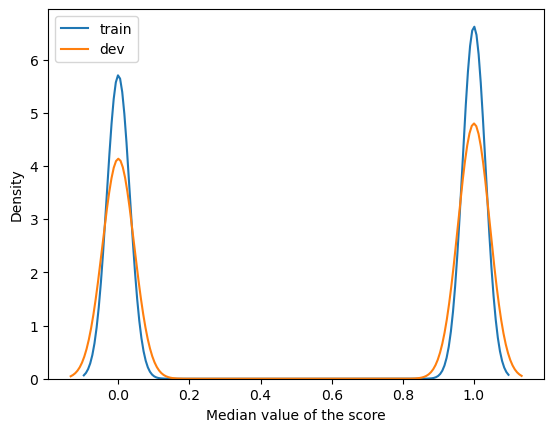

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.kdeplot(y, label='train')
sns.kdeplot(y_dev_test, ax=ax, label='dev');
plt.legend()
plt.ylabel('Density');
plt.xlabel('Median value of the score');

In [98]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

### Trying some classification algorithms

In [99]:
#DEV SET
from sklearn.linear_model import LogisticRegression  
logreg = LogisticRegression(random_state=42)
logreg.fit(x_train, y_train)
y_dev_pred = logreg.predict(x_dev_test)
print(classification_report(y_dev_test, y_dev_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     80324
           1       0.54      1.00      0.70     93197

    accuracy                           0.54    173521
   macro avg       0.27      0.50      0.35    173521
weighted avg       0.29      0.54      0.38    173521



C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [100]:
# TEST SET
from sklearn.linear_model import LogisticRegression  
logreg = LogisticRegression(random_state=42)
logreg.fit(X, y)
y_test_pred = logreg.predict(X_test)
print(classification_report(y_test, y_test_pred))

C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    206928
           1       0.51      1.00      0.67    213728

    accuracy                           0.51    420656
   macro avg       0.25      0.50      0.34    420656
weighted avg       0.26      0.51      0.34    420656



C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [101]:
# DEV SET
from sklearn.ensemble import AdaBoostClassifier
ada_classifier = AdaBoostClassifier(n_estimators=30, learning_rate=0.1, random_state=42)
ada_classifier.fit(x_train, y_train)
y_test_pred = ada_classifier.predict(x_dev_test)
print(classification_report(y_dev_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.70      0.58      0.64     80324
           1       0.69      0.79      0.73     93197

    accuracy                           0.69    173521
   macro avg       0.69      0.68      0.68    173521
weighted avg       0.69      0.69      0.69    173521



In [102]:
# TEST SET
from sklearn.ensemble import AdaBoostClassifier
ada_classifier = AdaBoostClassifier(n_estimators=30, learning_rate=0.1, random_state=42)
ada_classifier.fit(X, y)
y_test_pred = ada_classifier.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.69      0.45      0.54    206928
           1       0.60      0.81      0.69    213728

    accuracy                           0.63    420656
   macro avg       0.65      0.63      0.62    420656
weighted avg       0.65      0.63      0.62    420656



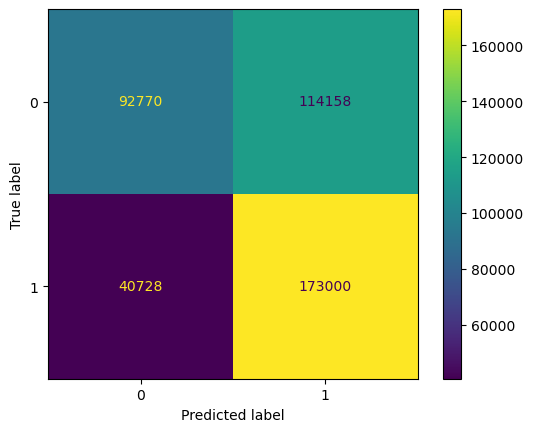

In [73]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred);

In [82]:
# DEV SET
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=30, max_depth=2, random_state=42)
rf_classifier.fit(x_train, y_train)
y_test_pred = rf_classifier.predict(x_dev_test)
print(classification_report(y_dev_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.68      0.59      0.64     80324
           1       0.69      0.76      0.72     93197

    accuracy                           0.68    173521
   macro avg       0.68      0.68      0.68    173521
weighted avg       0.68      0.68      0.68    173521



In [74]:
# TEST SET
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=30, max_depth=2, random_state=42)
rf_classifier.fit(X,y)
y_test_pred = rf_classifier.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.70      0.49      0.57    206928
           1       0.62      0.79      0.69    213728

    accuracy                           0.64    420656
   macro avg       0.66      0.64      0.63    420656
weighted avg       0.65      0.64      0.63    420656



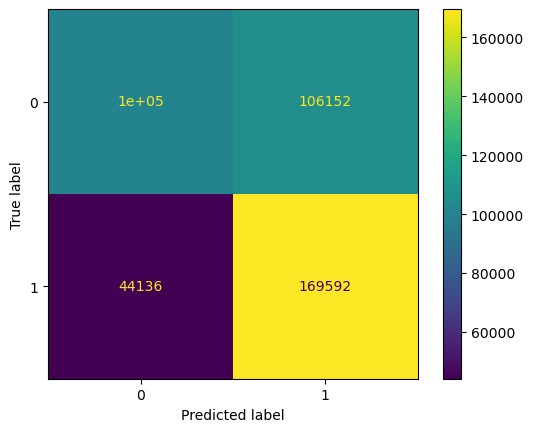

In [75]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred);

In [133]:
#  DEV SET
from sklearn.ensemble import GradientBoostingClassifier
clf_model = GradientBoostingClassifier(n_estimators=40, min_samples_split=2, random_state=42)
clf_model.fit(x_train, y_train)
clf_predictions = clf_model.predict(x_dev_test)
print(classification_report(y_dev_test, clf_predictions))

              precision    recall  f1-score   support

           0       0.77      0.76      0.77     80324
           1       0.80      0.80      0.80     93197

    accuracy                           0.78    173521
   macro avg       0.78      0.78      0.78    173521
weighted avg       0.78      0.78      0.78    173521



In [134]:
# TEST SET
from sklearn.ensemble import GradientBoostingClassifier
clf_model = GradientBoostingClassifier(n_estimators=40, min_samples_split=2, random_state=42)
clf_model.fit(X, y)
clf_predictions = clf_model.predict(X_test)
print(classification_report(y_test, clf_predictions))

              precision    recall  f1-score   support

           0       0.76      0.56      0.64    206928
           1       0.66      0.83      0.74    213728

    accuracy                           0.70    420656
   macro avg       0.71      0.69      0.69    420656
weighted avg       0.71      0.70      0.69    420656



In [121]:
# DEV SET
from xgboost import XGBClassifier
bst = XGBClassifier(n_estimators=30, max_depth=3, gamma=2, learning_rate=0.1, objective='binary:logistic', random_state=42)
bst.fit(x_train, y_train)
preds = bst.predict(x_dev_test)
print(classification_report(y_dev_test, preds))

              precision    recall  f1-score   support

           0       0.76      0.75      0.75     80324
           1       0.78      0.80      0.79     93197

    accuracy                           0.77    173521
   macro avg       0.77      0.77      0.77    173521
weighted avg       0.77      0.77      0.77    173521



In [122]:
# TEST SET
from xgboost import XGBClassifier
bst = XGBClassifier(n_estimators=30, max_depth=3, gamma=2, learning_rate=1, objective='binary:logistic', random_state=42)
bst.fit(X, y)
preds = bst.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.81      0.60      0.69    206928
           1       0.69      0.86      0.77    213728

    accuracy                           0.74    420656
   macro avg       0.75      0.73      0.73    420656
weighted avg       0.75      0.74      0.73    420656



### With fabric info

In [104]:
f1 = pd.read_parquet("../generated_data/articles_with_first_5_fabric.parquet")
f1 = f1[["article_id", "cotton", "elastic", "jersey", "knit", "metal"]]
f1.head()

,article_id,cotton,elastic,jersey,knit,metal
0,108775015,0,0,1,0,0
1,108775044,0,0,1,0,0
2,108775051,0,0,1,0,0
3,110065001,0,0,0,0,0
4,110065002,0,0,0,0,0


In [105]:
Xf = X.merge(f1, on="article_id")
Xf_test = X_test.merge(f1, on="article_id")

In [106]:
Xf

,customer_id,article_id,price,sales_channel_id,week,product_code,prod_name,product_type_no,product_type_name,product_group_name,...,Active,club_member_status,fashion_news_frequency,age,postal_code,cotton,elastic,jersey,knit,metal
0,5316172648860712200,578472001,0.076254,2,102,578472,37340,263,38,0,...,-1,0,0,35,118426,0,0,0,0,0
1,588537301170199322,578472001,0.076254,2,102,578472,37340,263,38,0,...,-1,0,0,56,33394,0,0,0,0,0
2,7602796095362538028,578472001,0.076254,2,102,578472,37340,263,38,0,...,1,0,1,56,83235,0,0,0,0,0
3,9997353499039477636,578472001,0.076254,2,103,578472,37340,263,38,0,...,1,0,1,23,0,0,0,0,0,0
4,15296682392156192441,578472001,0.076254,2,102,578472,37340,263,38,0,...,-1,1,0,24,270806,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867600,1039210840243559212,912028002,0.067780,2,103,912028,26087,245,17,0,...,1,0,1,52,6183,0,0,0,1,0
867601,17918395686637739207,927936001,0.059305,2,103,927936,19827,252,2,0,...,1,0,1,58,13132,0,0,0,1,0
867602,1931712460480622356,927936001,0.059305,1,102,927936,19827,252,2,0,...,1,0,1,48,57092,0,0,0,1,0
867603,17920923891076718367,866945003,0.042356,2,103,866945,27968,255,3,0,...,1,0,1,56,279899,1,0,1,0,0


In [80]:
from sklearn.model_selection import train_test_split

xf_train, xf_dev_test, yf_train, yf_dev_test = train_test_split(Xf, y, test_size=0.2,
                                                    random_state=1234, stratify=y)

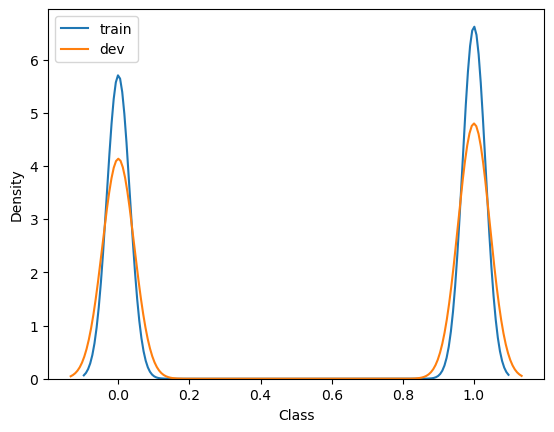

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.kdeplot(y, label='train')
sns.kdeplot(yf_dev_test, ax=ax, label='dev');
plt.legend()
plt.ylabel('Density');
plt.xlabel('Class');

In [82]:
# DEV SET
from sklearn.linear_model import LogisticRegression  
logreg = LogisticRegression(random_state=42)
logreg.fit(xf_train, yf_train)
y_test_pred = logreg.predict(xf_dev_test)
print(classification_report(yf_dev_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     80324
           1       0.54      1.00      0.70     93197

    accuracy                           0.54    173521
   macro avg       0.27      0.50      0.35    173521
weighted avg       0.29      0.54      0.38    173521



C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
# TEST SET
from sklearn.linear_model import LogisticRegression  
logreg = LogisticRegression(random_state=42)
logreg.fit(Xf, y)
y_test_pred = logreg.predict(Xf_test)
print(classification_report(y_test, y_test_pred))

C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    206928
           1       0.51      1.00      0.67    213728

    accuracy                           0.51    420656
   macro avg       0.25      0.50      0.34    420656
weighted avg       0.26      0.51      0.34    420656



C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lucre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [84]:
# DEV SET
from xgboost import XGBClassifier
bst = XGBClassifier(n_estimators=30, max_depth=3, gamma=2, learning_rate=1, objective='binary:logistic', random_state=42)
bst.fit(xf_train, yf_train)
preds = bst.predict(xf_dev_test)
print(classification_report(yf_dev_test, preds))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90     80324
           1       0.90      0.93      0.92     93197

    accuracy                           0.91    173521
   macro avg       0.91      0.91      0.91    173521
weighted avg       0.91      0.91      0.91    173521



In [85]:
# TEST SET
from xgboost import XGBClassifier
bst = XGBClassifier(n_estimators=30, max_depth=3, gamma=2, learning_rate=1, objective='binary:logistic', random_state=42)
bst.fit(Xf, y)
preds = bst.predict(Xf_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85    206928
           1       0.86      0.84      0.85    213728

    accuracy                           0.85    420656
   macro avg       0.85      0.85      0.85    420656
weighted avg       0.85      0.85      0.85    420656



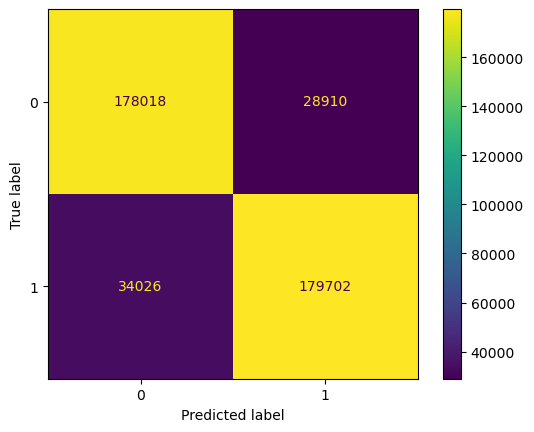

In [86]:
ConfusionMatrixDisplay.from_predictions(y_test, preds);

In [103]:
# DEV SET
from sklearn.ensemble import AdaBoostClassifier
ada_classifier = AdaBoostClassifier(n_estimators=25, learning_rate=0.1, random_state=42)
ada_classifier.fit(xf_train, yf_train)
y_test_pred = ada_classifier.predict(xf_dev_test)
print(classification_report(yf_dev_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78     80324
           1       0.79      0.88      0.83     93197

    accuracy                           0.81    173521
   macro avg       0.82      0.80      0.81    173521
weighted avg       0.81      0.81      0.81    173521



In [101]:
# TEST SET
from sklearn.ensemble import AdaBoostClassifier
ada_classifier = AdaBoostClassifier(n_estimators=25, learning_rate=0.1, random_state=42)
ada_classifier.fit(Xf, y)
y_test_pred = ada_classifier.predict(Xf_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.75      0.78    206928
           1       0.77      0.85      0.81    213728

    accuracy                           0.80    420656
   macro avg       0.80      0.80      0.80    420656
weighted avg       0.80      0.80      0.80    420656



In [138]:
# DEV SET
from sklearn.ensemble import GradientBoostingClassifier
clf_model = GradientBoostingClassifier(n_estimators=40, min_samples_split=2, random_state=42)
clf_model.fit(xf_train, yf_train)
clf_predictions = clf_model.predict(xf_dev_test)
print(classification_report(yf_dev_test, clf_predictions))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84     80324
           1       0.83      0.93      0.88     93197

    accuracy                           0.86    173521
   macro avg       0.87      0.86      0.86    173521
weighted avg       0.87      0.86      0.86    173521



In [136]:
# TEST SET
from sklearn.ensemble import GradientBoostingClassifier
clf_model = GradientBoostingClassifier(n_estimators=40, min_samples_split=2, random_state=42)
clf_model.fit(Xf, y)
clf_predictions = clf_model.predict(Xf_test)
print(classification_report(y_test, clf_predictions))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82    206928
           1       0.81      0.87      0.84    213728

    accuracy                           0.83    420656
   macro avg       0.84      0.83      0.83    420656
weighted avg       0.84      0.83      0.83    420656



In [93]:
# DEV SET
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=30, max_depth=2, random_state=42)
rf_classifier.fit(xf_train, yf_train)
y_test_pred = rf_classifier.predict(xf_dev_test)
print(classification_report(yf_dev_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78     80324
           1       0.79      0.88      0.83     93197

    accuracy                           0.81    173521
   macro avg       0.82      0.80      0.81    173521
weighted avg       0.81      0.81      0.81    173521



In [92]:
# TEST SET
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=30, max_depth=2, random_state=42)
rf_classifier.fit(Xf,y)
y_test_pred = rf_classifier.predict(Xf_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.75      0.78    206928
           1       0.77      0.85      0.81    213728

    accuracy                           0.80    420656
   macro avg       0.80      0.80      0.80    420656
weighted avg       0.80      0.80      0.80    420656



### Export

In [107]:
X_test.to_parquet("../generated_data/X_test_104.parquet", index=False)
Xf_test.to_parquet("../generated_data/Xf_test_104.parquet", index=False)

X.to_parquet("../generated_data/X_train_102103.parquet", index=False)
Xf.to_parquet("../generated_data/Xf_train_102103.parquet", index=False)

In [108]:
y_test.to_csv("../generated_data/y_test_104.csv", index = False)
y.to_csv("../generated_data/y_train_102103.csv", index = False)

In [109]:
type(y_test)

pandas.core.series.Series